# What is Machine Learning?

### Machine Learning Paradigms
- Supervised learning
- Unsupervised learning
- Reinforcement learning




Subfields of ML
- Neural Networks
- Statistical Algorithms
- 

# Supervised Learning

- **A Model**
    - Predict something given some data


## Inputs  

- Data you want to learn a representation of
- The input data can be viewed as a spreadsheet
    - Each row is a single input to our model
    - An input is composed of a set of features (columns in the spreadsheet)
   


## Targets
- What are we trying to predict?
- A target represents the ideal output of a model for a given input
- Commonly stored as the last column

<br/> 
<br/> 

| Height | Weight | Gender | Age | Smokes | % chance of developing heart disease over next yr |
| --- | --- | --- | --- | --- | --- |
| 71 | 165 | 1 | 27 | 0 | 0.053 |
| 68 | 137 | 0 | 41 | 1 | 0.170 |

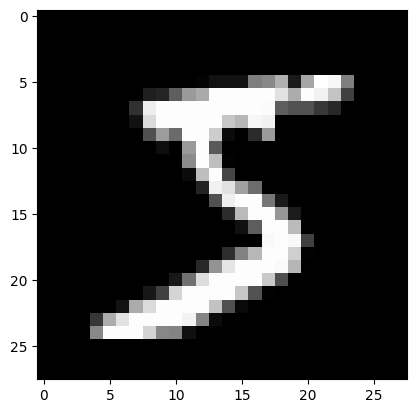

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

batchSize = 32

mnistDataset = datasets.MNIST('./data', train=True, download=True, 
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize(
                                        (0.1307,), (0.3081,))
                                ]))

mnistExample = DataLoader(mnistDataset, batch_size=1)
batchIdx, (exampleInput, exampleTarget) = next(enumerate(mnistExample))
x = exampleInput.detach().numpy().squeeze()
plt.imshow(x, cmap='gray')
plt.show()



### A, b, c, d... 

- $x$ collection of input data, a collection of vectors
    - $x_i$ individual sample of $x$
- $n$ number of samples
- $f$ model (function)
- $y$ collection of targets/labels, while the desired output for each sample in $x$
    - Ground truth label  
- $\hat{y}$ output of our model (y-hat)  
    


### Representations

- The goal of our model is to learn a representation of $ f(x) = y $
- The actual output of our model is $f(x) = \hat{y}$
- What our model/function does:
    - For each individual vector $x_i$ give us an output $\hat{y_i}$ that is as close to the ground truth $y_i$ as possible
- Ideal: $\forall{x_i} \in \: x,\space f(x_i) = \hat{y_i} = y_i$ 

### Neural Network

- For a fully connected feed forward nueral network...
    - Composed of layers of neurons
    - Fully connected
    - Input size is equal to number of features
    - output size depends on target


<img src="images/A-fully-connected-neural-network-with-two-hidden-layers.png" width="400">



### Neurons

<img src="images/neuron.png" width="400">




- Layers of a network are composed of neurons
- In a fully connected network, each neuron from a layer is connected to every other neuron in an adjacent layer
- For every connection, there is a $w^k_{ij} \in \mathbb{R}$
    - $i$ inputs index
    - $j$ outputs index
    - $k$ index of layer
- For every layer



### Error

- How inaccurate is our model?

- $E = MAE = \dfrac{|\hat{y} - y|}{n} = \dfrac{\sum_{i}^{n}{|\hat{y}_i - y_i|}}{n} = L1$

- $E = MSE = \dfrac{(\hat{y} - y)^2}{n} = \dfrac{\sum_{i}^{n}{(\hat{y}_i - y_i)^2}}{n} = L2$
- Ex:
    - $y = [1, 2, 3]$
    - $\hat{y} = [7, 2, -2]$
    
    - $MAE = \dfrac{(7-1)+(2-2)+(-2-3)}{3}$

### Loss

- Your error & loss function are coupled 
- Your error function must be differentiable
- $C = loss fn = (Cost function)$
- $SqErr = e_i = (\hat{y_i} - y_i)^2$  

- $SEL = C = 2(\hat{y} - y)$
    - $(\hat{y} - y)$


### Overview

1. Determine what the input data for the model will be
2. Build training dataset
    - inputs & target/label for each sample
3. Determine what type of learning model to use & the structure of it
    - NN, Random Forest, Gradient Boost, etc.
4. Set hyperparameters & run the model over the training set
    - Usually model will process the training set in batches of samples
    - Walk the model down the optimization landscape
5. Determine accuracy of model/function on the so far unused test-set data